In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, OneClassSVM
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score, confusion_matrix, recall_score

# How big is train dataset ?
train_test_ratio = 0.039
np.random.RandomState(seed=42)

data_path = os.path.abspath(os.path.join(os.getcwd(), '..',  'dataset'))

frames = []

frames.append(pd.read_csv(os.path.join(data_path, "UNSW-NB15_1_anonymized_new.csv")))
# Uncomment to load all csv
frames.append(pd.read_csv(os.path.join(data_path, "UNSW-NB15_2_anonymized_new.csv")))
frames.append(pd.read_csv(os.path.join(data_path, "UNSW-NB15_3_anonymized_new.csv")))
frames.append(pd.read_csv(os.path.join(data_path, "UNSW-NB15_4_anonymized_new.csv")))

df = pd.concat(frames, axis=0, ignore_index=True)

mask = np.random.rand(len(df)) < train_test_ratio
train = df[mask]
test = df[~mask]

# Clear memory
del df

train.head()

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/ADATASSD512/PWR/Semestr-3/Cyberbezpieczenstwo/dataset/UNSW-NB15_1_anonymized_new.csv'

In [39]:
# Info about data types and columns
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99003 entries, 14 to 2540003
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   srcip             99003 non-null  object 
 1   dstip             99003 non-null  object 
 2   proto             99003 non-null  object 
 3   state             99003 non-null  object 
 4   dur               99003 non-null  float64
 5   sbytes            99003 non-null  int64  
 6   dbytes            99003 non-null  int64  
 7   sttl              99003 non-null  int64  
 8   dttl              99003 non-null  int64  
 9   sloss             99003 non-null  int64  
 10  dloss             99003 non-null  int64  
 11  service           99003 non-null  object 
 12  Sload             99003 non-null  float64
 13  Dload             99003 non-null  float64
 14  Spkts             99003 non-null  int64  
 15  Dpkts             99003 non-null  int64  
 16  swin              99003 non-null  int

In [40]:
# Count null values in columns
test.isnull().sum()

srcip               0
dstip               0
proto               0
state               0
dur                 0
sbytes              0
dbytes              0
sttl                0
dttl                0
sloss               0
dloss               0
service             0
Sload               0
Dload               0
Spkts               0
Dpkts               0
swin                0
dwin                0
stcpb               0
dtcpb               0
smeansz             0
dmeansz             0
trans_depth         0
res_bdy_len         0
Sjit                0
Djit                0
Sintpkt             0
Dintpkt             0
tcprtt              0
synack              0
ackdat              0
is_sm_ips_ports     0
ct_state_ttl        0
ct_flw_http_mthd    0
is_ftp_login        0
ct_ftp_cmd          0
ct_srv_src          0
ct_srv_dst          0
ct_dst_ltm          0
ct_src_ ltm         0
ct_src_dport_ltm    0
ct_dst_sport_ltm    0
ct_dst_src_ltm      0
attack_cat          0
Label               0
dtype: int

In [41]:
# How many attacks and normal records do we have ?
train['Label'].value_counts()

0    86442
1    12561
Name: Label, dtype: int64

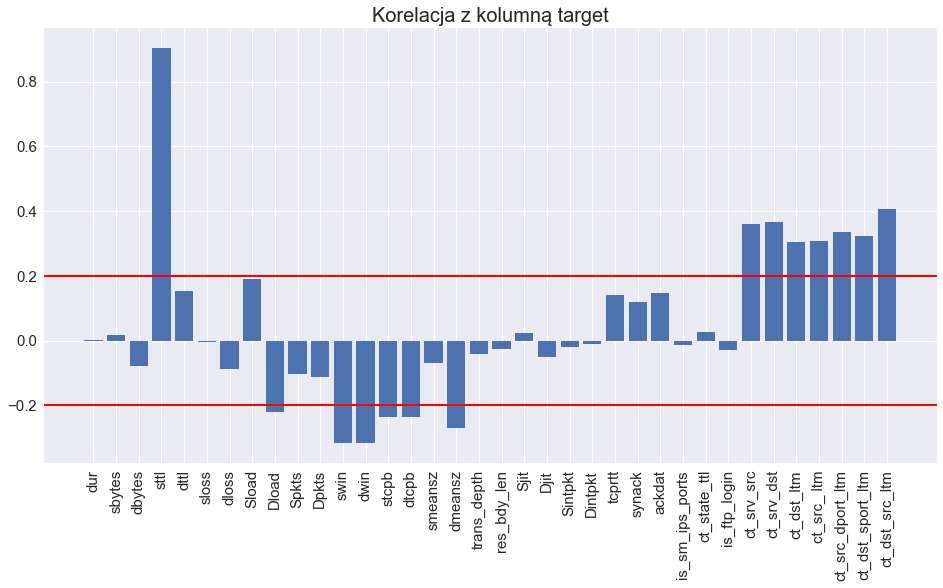

In [42]:
correlation = train.corr()['Label']
correlation = correlation.drop('Label')

plt.style.use('seaborn')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

plt.figure(figsize=(16,8))
plt.bar(correlation.keys(), correlation.tolist())
plt.title('Korelacja z kolumną target', size=20)
plt.xticks(rotation=90)
plt.axhline(y=0.2, linewidth=2, color='r')
plt.axhline(y=-0.2, linewidth=2, color='r')
plt.show()

In [43]:
corr_dict = correlation.to_dict()
correlation_treshold = 0.2

# Return column names where correlation is greater or equal than threshold
column_names = [key for key, value in corr_dict.items() if abs(value) >= correlation_treshold]
column_names

['sttl',
 'Dload',
 'swin',
 'dwin',
 'stcpb',
 'dtcpb',
 'dmeansz',
 'ct_srv_src',
 'ct_srv_dst',
 'ct_dst_ltm',
 'ct_src_ ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm']

In [44]:
scaler = StandardScaler()

X_train = scaler.fit_transform(train[column_names])
y_train = train['Label']
# del train

X_test = scaler.transform(test[column_names])
y_test = test['Label']
# del test

In [45]:
classifiers = {
    'logreg': LogisticRegression(),
    'forest': RandomForestClassifier(),
    'gradboost': GradientBoostingClassifier(),
    'svc': SVC(),
    'mlp': MLPClassifier()
}

In [46]:
results = []
conf_matrix = {}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    results.append([name, f1, prec, rec, acc])
    conf_matrix[name] = confusion_matrix(y_test, y_pred)
    
df_results = pd.DataFrame(results, columns=['model', 'f1', 'precision', 'recall', 'accuracy'])

In [47]:
df_results.round(4)

,model,f1,precision,recall,accuracy
0,logreg,0.9177,0.9075,0.9281,0.9789
1,forest,0.9465,0.9389,0.9543,0.9864
2,gradboost,0.9514,0.9214,0.9835,0.9873
3,svc,0.9422,0.9064,0.9810,0.9848
4,mlp,0.9455,0.9084,0.9858,0.9856


In [48]:
for key, item in conf_matrix.items():
    conf_matrix[key] = item / len(test)

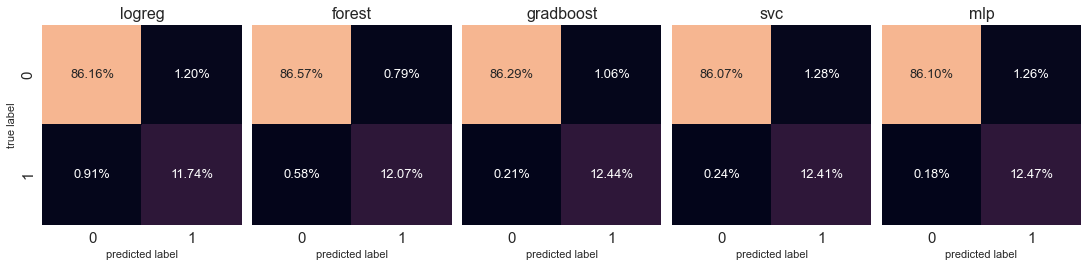

In [49]:
fig, axes = plt.subplots(1, 5, figsize=(15, 6), sharey=True, sharex=True, constrained_layout=True)
axes = axes.flatten()

for i, (model, cm) in enumerate(conf_matrix.items()):
    ax = axes[i]
    sns.heatmap(cm, ax=ax, annot=True, square=True, cbar=False,
                fmt=".2%", vmin=0, vmax=cm.sum().sum(), annot_kws={'size': 13})
    
    ax.set_title(model, fontsize=16)
    ax.margins(0)
    ax.grid(False)
    
    if i == 0:
        ax.set_ylabel('true label')
    ax.set_xlabel('predicted label')